### Elo Ranking MCMC

Sample: 100%|██| 200/200 [00:19, 10.45it/s, step size=5.29e-01, acc. prob=0.890]


Player Rankings (Elo):
dc9bba8ad4691996: 1077.532676928013
39d3999e618f7979: 1070.634250787918
dbc353fca44ddc63: 1068.2985681967364
3c59e9278d46a9c2: 1061.132567476623
200cb75115f91643: 1061.084987851813
4247049116327144: 1060.6309821539126
3c47542a8c70cd6d: 1059.5437599539305
75e35522860c1e28: 1057.9321098697656
d82db8b6eb5fcb68: 1054.302120390593
90d18911740393d5: 1047.0668503972786
b7b333dc171742e1: 1045.8586244348296
d474540874b4c1e2: 1045.1805197567712
ef9a28e181420841: 1044.9587184662987
6f324be57a3097a9: 1044.3679230817013
199799cf26a89281: 1043.9935950205108
b8ecf1fc4559386a: 1043.8922158980145
6998394353477dab: 1043.0950143253817
388ae11b3d5355bc: 1042.9863552335405
d6f482b02785441b: 1042.944790086434
f670669770bff11f: 1042.1543007012342
4d674ea357600f12: 1041.8838065143923
49e9890bd7cd8b98: 1041.270570377127
9fc9f31c85fa35d1: 1041.153181675641
edf22f5457bc3782: 1040.6979513923407
78023ab2d0c2de88: 1035.0711694484896
e45b1c3ec372d088: 1032.5028171779454
9cbda0eca85bd0fc: 1032.

Sample: 100%|██| 200/200 [06:04,  1.82s/it, step size=3.42e-01, acc. prob=0.881]


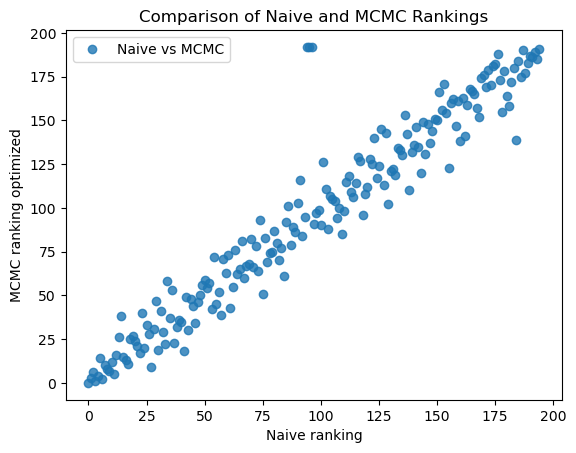

In [2]:
import matplotlib.pyplot as plt
import pyGMs as gm
import numpy as np
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import pyro.poutine as poutine

import pandas as pd

seed = 123
pyro.set_rng_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
import pandas as pd
import pyro
import pyro.distributions as dist
import torch
import random
import matplotlib.pyplot as plt

# Convert to DataFrame
data = pd.read_csv('data.csv')
df = pd.DataFrame(data)

# Initialize team ratings
def initialize_ratings(teams, initial_rating=1000):
    return {team: initial_rating for team in teams}

# Select matches using a heuristic approach
def select_matches(teams, ratings, num_matches):
    selected_matches = []
    team_list = list(teams)
    for _ in range(num_matches):
        team1, team2 = random.sample(team_list, 2)
        selected_matches.append((team1, team2, 1))
    return selected_matches

# Elo rating update
def update_elo_ratings(ratings, matches, k=32):
    for match in matches:
        winner, loser, _ = match
        rating_winner = ratings[winner]
        rating_loser = ratings[loser]
        expected_winner = 1 / (1 + 10 ** ((rating_loser - rating_winner) / 400))
        expected_loser = 1 / (1 + 10 ** ((rating_winner - rating_loser) / 400))
        
        ratings[winner] += k * (1 - expected_winner)
        ratings[loser] += k * (0 - expected_loser)
    return ratings

# Modified model with unique sample names
def model(matches):
    skills = {}
    for idx, match in enumerate(matches):
        i, j, w = match
        if i not in skills:
            skills[i] = pyro.sample(f"X_{i}", dist.Normal(0.0, 1.0))
        if j not in skills:
            skills[j] = pyro.sample(f"X_{j}", dist.Normal(0.0, 1.0))
        
        X_i = skills[i]
        X_j = skills[j]
        
        prob_winning = torch.sigmoid(X_i - X_j)
        pyro.sample(f"W_{idx}_{i}_{j}", dist.Bernoulli(prob_winning), obs=torch.tensor(float(w)))

def run_nuts(matches, warmup_steps=100, num_samples=100):
    nuts_kernel = pyro.infer.NUTS(model)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc.run(matches)
    return mcmc.get_samples()

# Example of running the navigator
teams = set(df['winner']).union(set(df['loser']))
ratings = initialize_ratings(teams)
num_rounds = 20
num_matches_per_round = 20

all_matches = []
for _ in range(num_rounds):
    matches = select_matches(teams, ratings, num_matches_per_round)
    all_matches.extend(matches)
    samples = run_nuts(matches, num_samples=100)
    ratings = update_elo_ratings(ratings, matches)

sorted_ratings = sorted(ratings.items(), key=lambda item: item[1], reverse=True)

print("Player Rankings (Elo):")
for player, rating in sorted_ratings:
    print(f'{player}: {rating}')

# Extract mean skill estimates from MCMC samples
mcmc_samples = run_nuts(all_matches, num_samples=100)
mcmc_skills = {k[2:]: torch.mean(v.float()).item() for k, v in mcmc_samples.items()}  # Removing the 'X_' prefix
sorted_mcmc_skills = sorted(mcmc_skills.items(), key=lambda item: item[1], reverse=True)

# Create rankings
naive_ranking = [player for player, _ in sorted_ratings]
mcmc_ranking_opt = [player for player, _ in sorted_mcmc_skills]

# Create ranking dictionaries for plotting
naive_ranking_dict = {player: rank for rank, player in enumerate(naive_ranking)}
mcmc_ranking_dict = {player: rank for rank, player in enumerate(mcmc_ranking_opt)}

# Plot the rankings
x = [naive_ranking_dict[player] for player in naive_ranking]
y = [mcmc_ranking_dict.get(player, max(mcmc_ranking_dict.values()) + 1) for player in naive_ranking]

plt.plot(x, y, 'o', alpha=0.8, label="Naive vs MCMC")
plt.xlabel("Naive ranking")
plt.ylabel("MCMC ranking optimized")
plt.title("Comparison of Naive and MCMC Rankings")
plt.legend()
plt.show()


### Mean Square error + graph

Mean Squared Error: 272.5487179487179

Naive Ranking vs MCMC Ranking Coordinates:
Naive Rank: 0, MCMC Rank: 0
Naive Rank: 1, MCMC Rank: 3
Naive Rank: 2, MCMC Rank: 6
Naive Rank: 3, MCMC Rank: 1
Naive Rank: 4, MCMC Rank: 4
Naive Rank: 5, MCMC Rank: 14
Naive Rank: 6, MCMC Rank: 2
Naive Rank: 7, MCMC Rank: 10
Naive Rank: 8, MCMC Rank: 8
Naive Rank: 9, MCMC Rank: 7
Naive Rank: 10, MCMC Rank: 12
Naive Rank: 11, MCMC Rank: 5
Naive Rank: 12, MCMC Rank: 16
Naive Rank: 13, MCMC Rank: 26
Naive Rank: 14, MCMC Rank: 38
Naive Rank: 15, MCMC Rank: 15
Naive Rank: 16, MCMC Rank: 13
Naive Rank: 17, MCMC Rank: 11
Naive Rank: 18, MCMC Rank: 25
Naive Rank: 19, MCMC Rank: 27
Naive Rank: 20, MCMC Rank: 24
Naive Rank: 21, MCMC Rank: 21
Naive Rank: 22, MCMC Rank: 17
Naive Rank: 23, MCMC Rank: 40
Naive Rank: 24, MCMC Rank: 20
Naive Rank: 25, MCMC Rank: 33
Naive Rank: 26, MCMC Rank: 28
Naive Rank: 27, MCMC Rank: 9
Naive Rank: 28, MCMC Rank: 31
Naive Rank: 29, MCMC Rank: 47
Naive Rank: 30, MCMC Rank: 19
Naive Ra

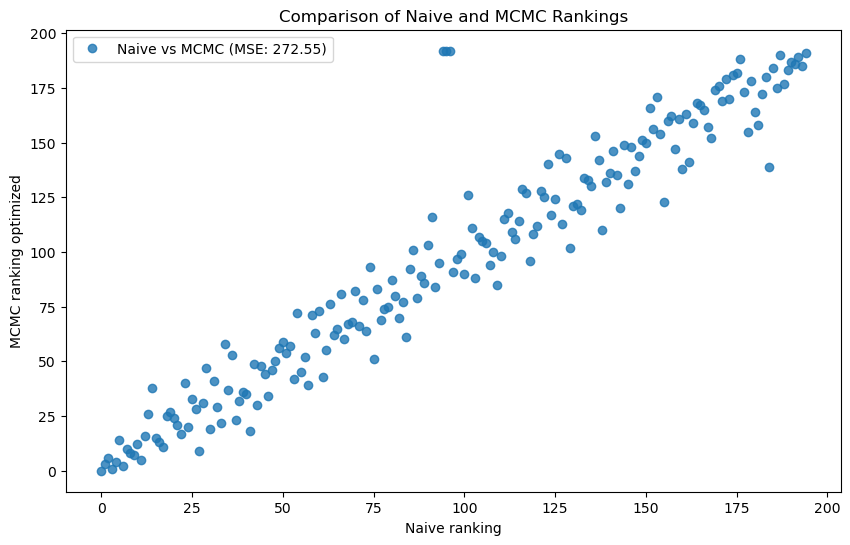

In [3]:
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error (MSE)
x = [naive_ranking_dict[player] for player in naive_ranking]
y = [mcmc_ranking_dict.get(player, max(mcmc_ranking_dict.values()) + 1) for player in naive_ranking]

mse = mean_squared_error(x, y)
print(f"Mean Squared Error: {mse}")

# coordinates side by side
print("\nNaive Ranking vs MCMC Ranking Coordinates:")
for naive_rank, mcmc_rank in zip(x, y):
    print(f"Naive Rank: {naive_rank}, MCMC Rank: {mcmc_rank}")

# Plot the rankings
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', alpha=0.8, label=f"Naive vs MCMC (MSE: {mse:.2f})")
plt.xlabel("Naive ranking")
plt.ylabel("MCMC ranking optimized")
plt.title("Comparison of Naive and MCMC Rankings")
plt.legend()
plt.show()